In [116]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from typing import Tuple, Dict, List, Union
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

examine the training set, within each segement folder `[COVID, Non-Covid, Normal]` there exist 3 subfolders:
`images, infection masks, lung masks` which provide the CXR imagery, lung mask - infected portion, ground truth lung mask.

In [28]:
test_lung = "covid_5.png"
test_cxr = Image.open(os.path.join("../data/Infection Segmentation Data/Train/COVID-19/images",test_lung))
test_infection_mask = Image.open(os.path.join("../data/Infection Segmentation Data/Train/COVID-19/infection masks",test_lung))
test_lung_mask = Image.open(os.path.join("../data/Infection Segmentation Data/Train/COVID-19/lung masks",test_lung))

chat generated helper function

In [30]:
def plot_images(images, titles=None):
    """
    Plots a list of PIL images side by side.
    
    Args:
        images (list): List of PIL images to plot.
        titles (list, optional): List of titles for each image. Default is None.
    """
    num_images = len(images)
    plt.figure(figsize=(num_images * 3, 3))
    
    for i, img in enumerate(images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')  # You can specify 'gray' for grayscale images
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])

    plt.tight_layout()
    plt.show()


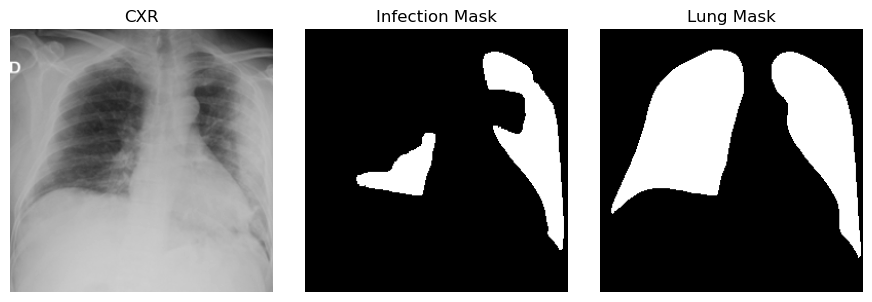

In [99]:
plot_images([test_cxr, test_infection_mask, test_lung_mask], ["CXR", "Infection Mask", "Lung Mask"])

Overlay the infection mask onto the ground truth lung mask (we may need an edge detection component)
- can we also distribute by the average lung size? so the number of pixels on the screen?
    - this may not exactly correspond to true lung size
- can we infer the sex of the patient from this?
- can we do some kind of clustering to extract features? or groups?
    - plot out the relative size of the lungs and see the distribution

![side by side comparison of lungs](C:\Users\02mat\Downloads\covid 20 and covid 11 side by side.png)

In [35]:
img = np.array(test_lung_mask.convert('L'))
np.sum(img == 255)

np.int64(19540)

In [38]:
img.size

65536

In [36]:
img.size

65536

In [43]:
train_lung_masks = os.path.join(r"C:\Users\02mat\OneDrive\Desktop\Year 4 - CMPE\capstone-federated-learning\data\Infection Segmentation Data\Train\COVID-19\lung masks")

In [100]:
# helper code to get size of lung masks
def get_mask_size(masks_path: str, mode: str = 'abs')->dict:
    assert(mode in ['abs', 'rel'])
    size_map = {}
    for file in os.listdir(masks_path):
        with Image.open(os.path.join(masks_path, file)) as img:
            np_img = np.array(img.convert('L'))             # convert image to gray-scale
            size = np.sum(np_img == 255)
            if mode == 'rel':
                size = size/np_img.size * 100               # check the number of pixels that are white (mask is binary, white and black)
            size_map[file] = size                           # return mask size 
    return size_map


In [79]:
covid_lung_mask_paths = r"C:\Users\02mat\OneDrive\Desktop\Year 4 - CMPE\capstone-federated-learning\data\Reformatted Data\COVID\lung masks"
non_covid_lung_mask_paths = r"C:\Users\02mat\OneDrive\Desktop\Year 4 - CMPE\capstone-federated-learning\data\Reformatted Data\Non-COVID\lung masks"
normal_lung_mask_paths = r"C:\Users\02mat\OneDrive\Desktop\Year 4 - CMPE\capstone-federated-learning\data\Reformatted Data\Normal\lung masks"

In [101]:
covid_lung_mask_sizes = get_mask_size(covid_lung_mask_paths, mode='rel')
non_covid_lung_mask_sizes = get_mask_size(non_covid_lung_mask_paths, mode='rel')
normal_lung_mask_sizes = get_mask_size(normal_lung_mask_paths, mode='rel')

In [102]:
len(covid_lung_mask_sizes)

2913

In [103]:
masks = [covid_lung_mask_sizes, non_covid_lung_mask_sizes, normal_lung_mask_sizes]

In [104]:
# fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
# for i, size in enumerate([covid_lung_mask_sizes, non_covid_lung_mask_sizes, normal_lung_mask_sizes]):
#     ax[i].hist(x=size.values(),bins=25)
#     ax[i].set_title(f"Segment {i}")
# plt.tight_layout()
# plt.show()

In [ ]:
plt.hist(covid_lung_mask_sizes.values(), label='COVID')
plt.hist(non_covid_lung_mask_sizes.values(), label='Non-COVID')
plt.hist(normal_lung_mask_sizes.values())

In [105]:
def plot_overlay_histograms(datasets, colors=None, bins=10, alpha=0.5):
    """
    Plots histograms of multiple datasets overlaid on a single plot.
    
    Parameters:
    - datasets: List of datasets (arrays or lists) to be plotted.
    - colors: List of colors for each histogram. If None, random colors will be chosen.
    - bins: Number of bins for the histograms.
    - alpha: Transparency level for each histogram to help distinguish overlapping areas.
    """
    n = len(datasets)

    labels = ['COVID', 'Non-COVID', 'Normal']
    
    # Set colors if not provided
    if colors is None:
        colors = plt.cm.viridis(np.linspace(0, 1, n))
    
    # Create the overlay plot
    plt.figure(figsize=(8, 6))
    
    # Plot each dataset as an overlaid histogram
    for i, (data, color) in enumerate(zip(datasets, colors)):
        plt.hist(data.values(), bins=bins, color=color, alpha=alpha, edgecolor='black', label=labels[i])
    
    # Adding labels and legend
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Overlayed Histograms')
    plt.legend()
    
    # Display the plot
    plt.show()

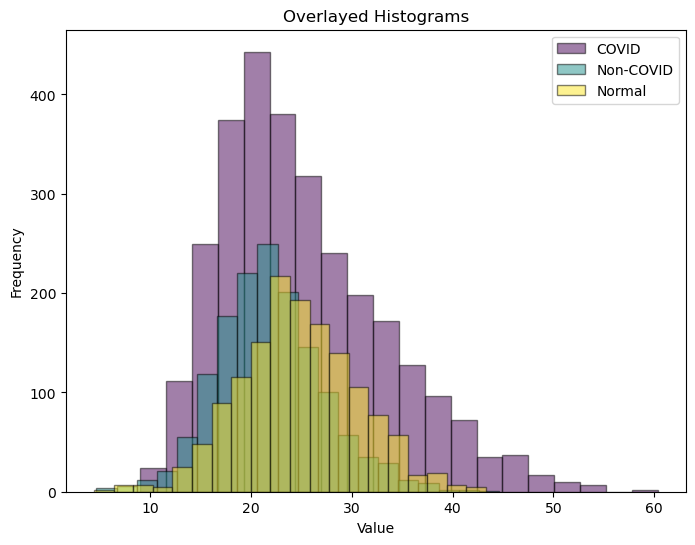

In [137]:
plot_overlay_histograms(masks, bins=20)

In [134]:
size_df = pd.concat([pd.DataFrame.from_dict(mask, orient='index') for mask in masks]).rename(columns={0:"Size_perc"})

In [136]:
size_df.describe()

,Size_perc
count,5826.000000
mean,24.242002
std,7.187779
min,4.469299
25%,19.228363
50%,23.268127
75%,28.173828
max,60.336304


In [131]:
pd.DataFrame.from_dict(masks[0], orient='index')

,0
covid_1.png,15.640259
covid_100.png,17.010498
covid_1000.png,35.902405
covid_1001.png,23.542786
covid_1002.png,30.120850
...,...
covid_994.png,17.378235
covid_995.png,45.681763
covid_997.png,24.255371
covid_998.png,10.682678


In [129]:
masks[0]

{'covid_1.png': np.float64(15.6402587890625),
 'covid_100.png': np.float64(17.010498046875),
 'covid_1000.png': np.float64(35.90240478515625),
 'covid_1001.png': np.float64(23.54278564453125),
 'covid_1002.png': np.float64(30.120849609375),
 'covid_1007.png': np.float64(30.64422607421875),
 'covid_1008.png': np.float64(41.24908447265625),
 'covid_1009.png': np.float64(18.8323974609375),
 'covid_101.png': np.float64(14.41192626953125),
 'covid_1010.png': np.float64(16.29486083984375),
 'covid_1011.png': np.float64(14.27764892578125),
 'covid_1014.png': np.float64(25.11444091796875),
 'covid_1015.png': np.float64(29.6539306640625),
 'covid_1016.png': np.float64(25.54931640625),
 'covid_1018.png': np.float64(25.335693359375),
 'covid_1020.png': np.float64(20.32928466796875),
 'covid_1023.png': np.float64(16.0186767578125),
 'covid_1024.png': np.float64(22.63336181640625),
 'covid_1025.png': np.float64(15.13671875),
 'covid_1026.png': np.float64(31.9305419921875),
 'covid_1028.png': np.flo

In [114]:
list(covid_lung_mask_sizes.values())

[np.float64(15.6402587890625),
 np.float64(17.010498046875),
 np.float64(35.90240478515625),
 np.float64(23.54278564453125),
 np.float64(30.120849609375),
 np.float64(30.64422607421875),
 np.float64(41.24908447265625),
 np.float64(18.8323974609375),
 np.float64(14.41192626953125),
 np.float64(16.29486083984375),
 np.float64(14.27764892578125),
 np.float64(25.11444091796875),
 np.float64(29.6539306640625),
 np.float64(25.54931640625),
 np.float64(25.335693359375),
 np.float64(20.32928466796875),
 np.float64(16.0186767578125),
 np.float64(22.63336181640625),
 np.float64(15.13671875),
 np.float64(31.9305419921875),
 np.float64(19.64111328125),
 np.float64(19.09027099609375),
 np.float64(24.0234375),
 np.float64(33.89739990234375),
 np.float64(36.2518310546875),
 np.float64(25.54931640625),
 np.float64(27.6824951171875),
 np.float64(19.46868896484375),
 np.float64(34.65728759765625),
 np.float64(32.32421875),
 np.float64(29.7454833984375),
 np.float64(16.06292724609375),
 np.float64(23.561

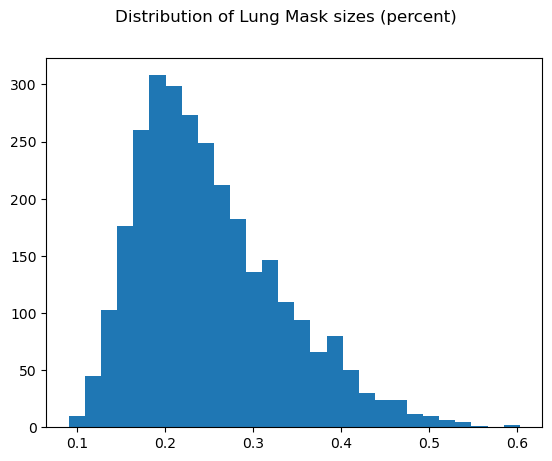

In [77]:
plt.hist(x=covid_lung_mask_sizes.values(), bins=28)
plt.suptitle("Distribution of Lung Mask sizes (percent)")
plt.show()

In [63]:
train_lung_mask_sizes = {}
size_for_plotting = []
for file in os.listdir(train_lung_masks):
    with Image.open(os.path.join(train_lung_masks, file)) as img:
        np_img = np.array(img.convert('L'))             # convert image to gray-scale
        mask_size = np.sum(np_img == 255)/np_img.size      # check the number of pixels that are white (mask is binary, white and black)
        train_lung_mask_sizes[file] = mask_size         # return mask size 
        size_for_plotting.append(mask_size)

Analysis of distribution of data

In [5]:
data\Infection Segmentation Data\Infection Segmentation Data\Train\COVID-19\images\covid_5.png

['COVID-QU-Ex dataset.txt', 'Infection Segmentation Data']